# Forecasts and Predictions
## Project Description 
The gym chain Model Fitness is developing a customer interaction strategy based on analytical data. In order to fight churn, Model Fitness has digitized a number of its customer profiles.    
My task is to analyze them and come up with a customer retention strategy.   
- Learn to predict the probability of churn (for the upcoming month) for each customer
- Draw up typical user portraits: select the most outstanding groups and describe their main features
- Analyze the factors that impact churn most
- Draw basic conclusions and develop recommendations on how to improve customer service:
    - Identify target groups
    - Suggest measures to cut churn
    - Describe any other patterns you see with respect to interaction with customers

## Table of Contents <a class="anchor" id="go_up"></a>

* [Step 1. Downloading the data file and reading the general information](#step_1)
* [Step 2. Exploratory data analysis (EDA)](#step_2)
    * [2.1. Missing features. Mean values and standart deviation](#step_2_1)
    * [2.2. Mean feature values for two groups](#step_2_2)
    * [2.3. Bar histograms and feature distributions for two groups](#step_2_3)
    * [2.4. Correlation matrix](#step_2_4)
* [Step 3. Building a model to predict user churn](#step_3)    
    * [3.1. Dividing the data into train and validation sets](#step_3_1)
    * [3.2. Training the model on the train set with Logistic Regression method](#step_3_2)       
    * [3.3. Training the model on the train set with Random Forest method](#step_3_3)
    * [3.4. Training the model on the train set with Decision Tree method](#step_3_4)
    * [3.5. Training the model on the train set with Gradient Boosting method](#step_3_5)
    * [3.6. Accuracy, precision, and recall for both models](#step_3_6)
    * [3.7. Comparing the models](#step_3_7)
    * [3.8. Importance of Features](#step_3_8)    
* [Step 4. Creating user clusters](#step_4) 
    * [4.1. Standardizing the data](#step_4_1)
    * [4.2. Matrix of distances and dendrogram](#step_4_2)
    * [4.3. Training the clustering model with the K-means algorithm](#step_4_3)
    * [4.4. Mean feature values for clusters](#step_4_4)
    * [4.5. Distributions of features for the clusters](#step_4_5)
    * [4.6. Calculating the churn rate for the clusters](#step_4_6)
* [Step 5. Conclusions and basic recommendations on working with customers](#step_5)
* [General conclusion](#step_6)

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import time
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas.util.testing as tm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix, silhouette_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

[To the Table of Contents](#go_up)   
## Step 1. <a class="anchor" id="step_1"></a>Downloading the data and reading the general information

In [2]:
location1 = 'D:/Dropbox/Practicum/13_Forecasts and Predictions/Project/'
location2 = '/datasets/'

colors = ['blue','green','red','purple','yellow']
#colors = ['#00ffdf','#00d8bd','#00bda5','#009f8b','#007667','#91f9e5','#76f7bf','#5fdd9d','#499167','#1c6747']
#colors2 = ['#544cbd','#508fed','#8bd6f3','#a8e9dd','#d9ece0','#7400b8','#6930c3','#48bfe3','#72efdd','#80ffdb']

In [3]:
filename = 'gym_churn_us.csv'
try:
    gym = pd.read_csv(os.path.join(location2,filename))
except:
    gym = pd.read_csv(os.path.join(location1,filename))
gym.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

There're 14 columns and 4000 entries, 4 of them float and 10 - integer. There are no missing values   
   
Current dataset fields:   
`gender` —    0 means female, 1 means male   
`Near_Location` — whether the user lives or works in the neighborhood where the gym is located   
`Partner` — whether the user is an employee of a partner company (the gym has partner companies whose employees get discounts; in those cases the gym stores information on customers' employers)   
`Promo_friends` — whether the user originally signed up through a "bring a friend" offer (they used a friend's promo code when paying for their first membership)   
`Phone` — whether the user provided their phone number   
`Contract_period` — 1 month, 3 months, 6 months, or 1 year   
`Group_visits` — whether the user takes part in group sessions   
`Age` — age of the user    
`Avg_additional_charges_total` — the total amount of money spent on other gym services: cafe, athletic goods, cosmetics, massages, etc.   
`Month_to_end_contract` — the months remaining until the contract expires   
`Lifetime` — the time (in months) since the customer first came to the gym   
`Avg_class_frequency_total` — average frequency of visits per week over the customer's lifetime   
`Avg_class_frequency_current_month` — average frequency of visits per week over the preceding month   
`Churn` — the fact of churn for the month in question
   
Let's rename some columns   

In [4]:
gym = gym.rename(columns={'gender':'Gender','Near_Location':'Near_location',
                          'Avg_additional_charges_total':'Additional_charges_total'})

In [5]:
gym.head(10)

,Gender,Near_location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
5,1,1,0,0,1,1,1,34,450.743960,1.0,3,2.623477,2.637007,0
6,1,1,1,1,0,6,1,32,94.266389,6.0,2,1.138941,1.277242,0
7,0,1,0,0,1,1,0,30,217.786641,1.0,0,1.213502,1.049387,1
8,1,1,1,1,1,1,1,23,45.409909,1.0,1,1.106239,1.059333,0
9,0,1,0,0,1,1,0,31,65.310836,1.0,11,1.810852,1.951368,0


In [6]:
gym.tail(10)

,Gender,Near_location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
3990,1,0,1,0,1,12,0,33,31.771147,8.0,10,1.831577,1.924509,0
3991,1,0,1,0,1,6,0,33,69.301270,6.0,1,1.367289,1.435721,0
3992,0,1,1,1,1,12,0,31,223.102448,8.0,4,3.855916,3.797062,0
3993,0,1,1,0,1,1,0,33,231.778628,1.0,3,1.418791,1.450442,0
3994,1,1,0,0,1,1,0,26,31.066721,1.0,1,1.157451,0.269597,1
3995,1,1,1,0,1,12,0,33,2.406023,12.0,8,2.284497,2.349070,0
3996,0,1,0,0,1,1,1,29,68.883764,1.0,1,1.277168,0.292859,1
3997,1,1,1,1,1,12,0,28,78.250542,11.0,2,2.786146,2.831439,0
3998,0,1,1,1,1,6,0,32,61.912657,5.0,3,1.630108,1.596237,0
3999,1,0,1,0,0,12,1,30,178.861814,12.0,1,1.101832,1.035270,0


In [7]:
gym.sample(10)

,Gender,Near_location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
3321,0,1,1,0,1,1,1,32,287.648668,1.0,12,2.441094,2.471259,0
3913,1,1,0,0,1,1,1,34,148.579384,1.0,2,2.972774,3.096353,0
2105,0,1,0,0,1,1,0,34,58.408136,1.0,4,2.315428,2.214284,0
3911,0,1,0,0,1,6,1,24,134.766193,6.0,0,2.448758,2.139388,1
2882,0,1,0,0,1,1,1,32,74.869386,1.0,1,2.970161,2.931549,0
736,1,1,1,1,1,1,0,28,158.872713,1.0,2,0.825241,0.749740,0
2788,0,1,1,1,1,6,0,23,77.795506,6.0,0,1.795015,1.487449,1
12,0,1,1,1,1,1,1,33,148.418053,1.0,4,3.368606,3.391853,0
99,1,1,0,0,1,1,0,26,31.121603,1.0,3,1.746991,1.023474,1
3293,1,1,0,0,1,1,1,31,225.744906,1.0,4,1.562964,1.524219,0


The data was loaded and opened successfully. The original table has 14 columns and 4000 rows and contains information about the clients of the gym chain Model Fitness 

[To the Table of Contents](#go_up)   
## Step 2. <a class="anchor" id="step_2"></a>Exploratory data analysis (EDA)
One of the most common problems gyms and other services face is customer churn. How do they know if a customer is no longer with them? For a gym, it makes sense to say a customer has left if they don't come for a month. Of course, it's possible they're in Cancun and will resume their visits when they return, but's that's not a typical case. 

In [8]:
print('The ratio between classes:\n', \
      gym.groupby('Churn')['Gender'].agg({lambda x: 100*x.count()/len(gym),'count'}). \
      rename(columns={'<lambda_0>':'%','count':'Count'}))

The ratio between classes:
        Count       %
Churn               
0       2939  73.475
1       1061  26.525


According to the assumption, I will find all users who are not listed as `Churn`, but did not appear during the current month

In [9]:
gym.query('Avg_class_frequency_current_month == 0 and Churn == 0').Gender.count()

47

47 users have not visited gym during the last month, and therefore I will consider them to have left and change their `Churn` status to 1

In [10]:
gym['Churn'] = gym['Churn'].where(gym['Avg_class_frequency_current_month'] != 0, 1)

print('The ratio between classes:\n', \
      gym.groupby('Churn')['Gender'].agg({lambda x: 100*x.count()/len(gym),'count'}). \
      rename(columns={'<lambda_0>':'%','count':'Count'}))

The ratio between classes:
        Count     %
Churn             
0       2892  72.3
1       1108  27.7


As a result, the ratio of those who stayed and those who left slightly changed towards those who left.    
In addition in our future machine learning models, the value 0 of the `Avg_class_frequency_current_month` feature will be associated with the value 1 of the target variable `Churn`

In [11]:
gym[(gym['Avg_class_frequency_total'] == 0)&(gym['Avg_class_frequency_current_month'] != 0)].Gender.count()

29

There are 29 more users with feature `Avg_class_frequency_total` equal to 0, and feature `Avg_class_frequency_current_month` not equal to 0.    
If this is not an error, we can assume that `Avg_class_frequency_total` does not include data on `Avg_class_frequency_current_month`. But since these users visited the gym during the current month, we will count them as those who stayed.

[To the Table of Contents](#go_up)   
### 2.1.<a class="anchor" id="step_2_1"></a> Missing features. Mean values and standart deviation   
Look at the dataset: does it contain any missing features? Study the mean values and standard deviation (use the describe() method)

In [12]:
gym.describe().iloc[:,:9]

,Gender,Near_location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Additional_charges_total
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740


In [13]:
gym.describe().iloc[:,9:]

,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,4.322750,3.724750,1.879020,1.767052,0.277000
std,4.191297,3.749267,0.972245,1.052906,0.447572
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,3.000000,1.832768,1.719574,0.000000
75%,6.000000,5.000000,2.536078,2.510336,1.000000
max,12.000000,31.000000,6.023668,6.146783,1.000000


We have exactly half - 7 columns with binary values (`Gender`, `Near_location`, `Partner`, `Promo_friends`, `Phone`, `Group_visits`, `Churn`). The average value of a binary feature is equal to the frequency of the value 1. It is obvious that the standard deviation reaches a maximum when both binary values are equally probable.   
Therefore, features `Gender` and `Partner` -  with mean value 0.51 and 0.48 respectively - correspond to an almost equiprobable distribution, feature `Near_location` has an average value of 0.84, features `Promo_friends` - 0.3, `Phone` - 0.9, `Group_visits` - 0.41 and `Churn`- 0.27.   
For features `Contract_period`, `Month_to_end_contract`, `Lifetime` the average value is practically equal to standard deviation, which means that the distribution is positively skew.    
Feature `Age` has an almost normal distribution.    
The last 3 features - `Additional_charges_total`, `Avg_class_frequency_total` and `Avg_class_frequency_current_month` - in these cases, the mean is 1.5-2 times higher than the standard deviation.

[To the Table of Contents](#go_up)   
### 2.2.<a class="anchor" id="step_2_2"></a> Mean feature values for two groups  
Look at the mean feature values in two groups: for those who left (churn) and for those who stayed (use the groupby() method)

In [14]:
gym.groupby('Churn').mean().iloc[:,:9]

,Gender,Near_location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Additional_charges_total
Churn,,,,,,,,,
0,0.509682,0.872752,0.534578,0.353734,0.904564,5.745159,0.464039,29.98686,158.314165
1,0.511733,0.773466,0.361913,0.190433,0.900722,1.904332,0.277076,27.08935,117.265656


In [15]:
gym.groupby('Churn').mean().iloc[:,9:]

,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,
0,5.280083,4.709198,2.057728,2.060838
1,1.824007,1.155235,1.412571,1.000237


So, the average values of features for those who left and for those who stayed:    
We can see women and men (`Gender`) are represented in these groups approximately equally. The proximity of localization (`Near_location`) is only slightly higher for those who stayed. And the average value for the attributes `Partner`,` Promo_friends`, `Contract_period`,` Group_visits`, `Additional_charges_total`,` Month_to_end_contract`, `Lifetime`,` Avg_class_frequency_total`, `Avg_class_frequency_current_month` is higher in the group of those who continued to come to the gym.   
As for `Age`, on average, those that stayed are a little older than those that left.

[To the Table of Contents](#go_up)   
### 2.3.<a class="anchor" id="step_2_3"></a> Bar histograms and feature distributions for two groups   
Plot bar histograms and feature distributions for those who left (churn) and those who stayed.

First, I'll write a function that draws distribution plots for a given feature. It will be useful to us again later, for clusters.

In [16]:
def plot_dist(df, feature):
    plt.figure(figsize=(15,15))
    the_grid = GridSpec(5, 3)
    
    # place in grid for plot
    
    for i, column in enumerate(df.drop(feature, axis = 1).columns):
        plt.subplot(the_grid[i//3, i%3], title=column.replace('_',' '))
        values = len(df[column].unique())
        features = sorted(df[feature].unique())
        
    # continuous vs discrete
    
        if values > 12:    
            for i,x in enumerate(features):
                sns.distplot(df[df[feature] == x][column], hist = False, 
                             kde_kws = {'shade': True, 'linewidth': 3}, color=colors[i])
        else:
            sns.countplot(column, hue=feature, data=gym, palette=colors, alpha=.5, saturation=1)
            plt.gca().get_legend().remove()
            
     # xticks       
            if values == 2:
                if column == 'Gender':
                    plt.xticks(np.arange(values),('F','M'))
                    
     # legend             
                    if feature == 'Churn':
                        legend = ['Stayed','Left']
                    else:
                        legend = features
                    plt.legend(legend, shadow=True, fancybox=True, title=feature, loc='best')
                else:
                    plt.xticks(np.arange(values),('NO','YES'))
            else:
                plt.xticks(np.arange(values),[int(x) for x in sorted(df[column].unique())])
        plt.xlabel('')
        plt.ylabel('')

    plt.tight_layout()

    plt.suptitle('Feature distributions', fontsize=24, y=1.02)
    plt.show()

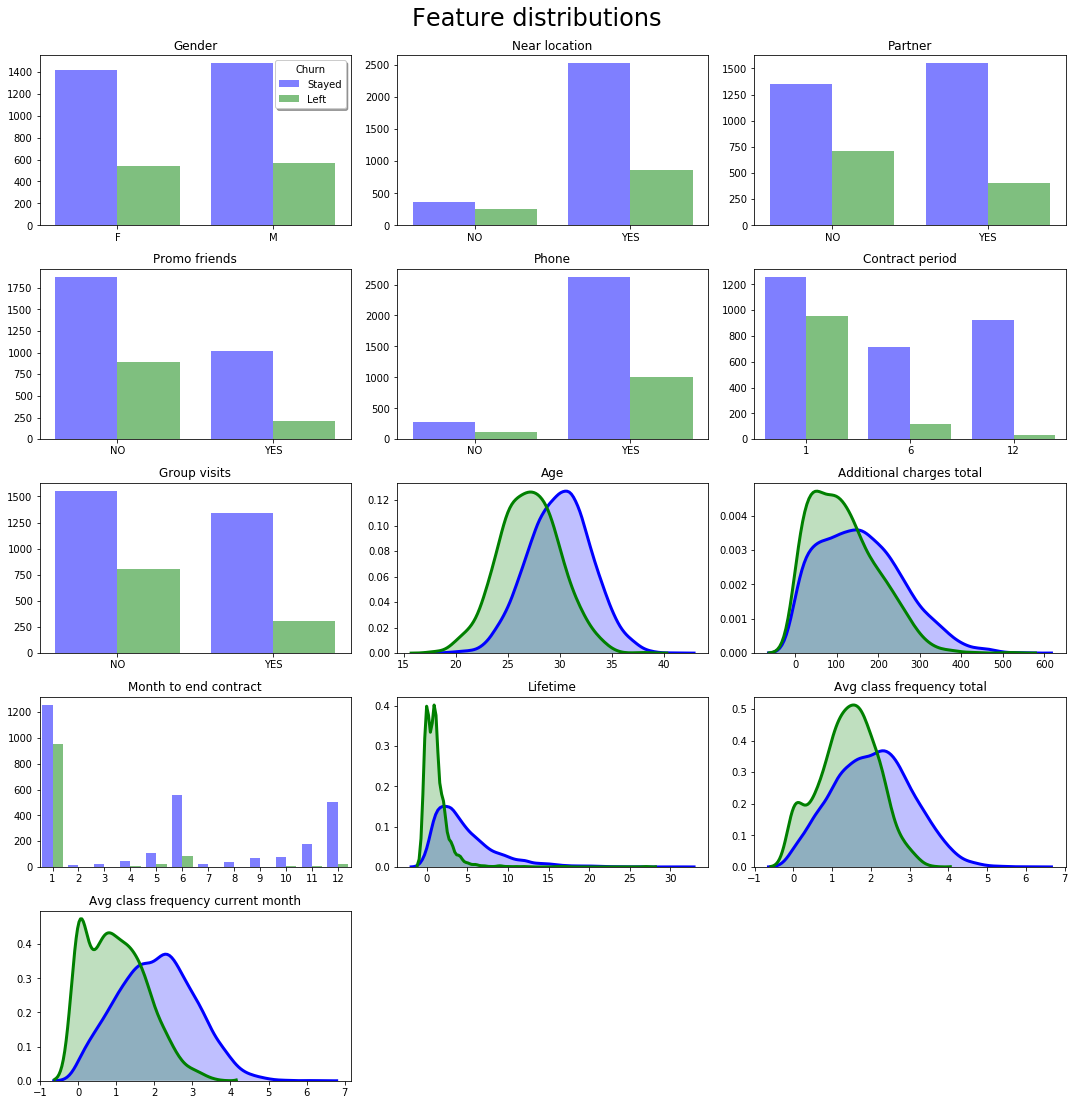

In [17]:
plot_dist(gym,'Churn')

In these plots, we can observe the distribution of features for those who left (churn) and those who stayed.   
Men and women in both groups are equally represented. The proximity to the gym promotes attendance, as does the discounts from the partner employer. The majority of users provide the phone numer, and the contract is longer for those who stayed. Those who left, a little younger, spend less money on additional services and went to the gym a little less often while they were still going.
Let's take a look at the correlation matrix of features

[To the Table of Contents](#go_up)   
### 2.4.<a class="anchor" id="step_2_4"></a> Correlation matrix   
Build a correlation matrix and display it

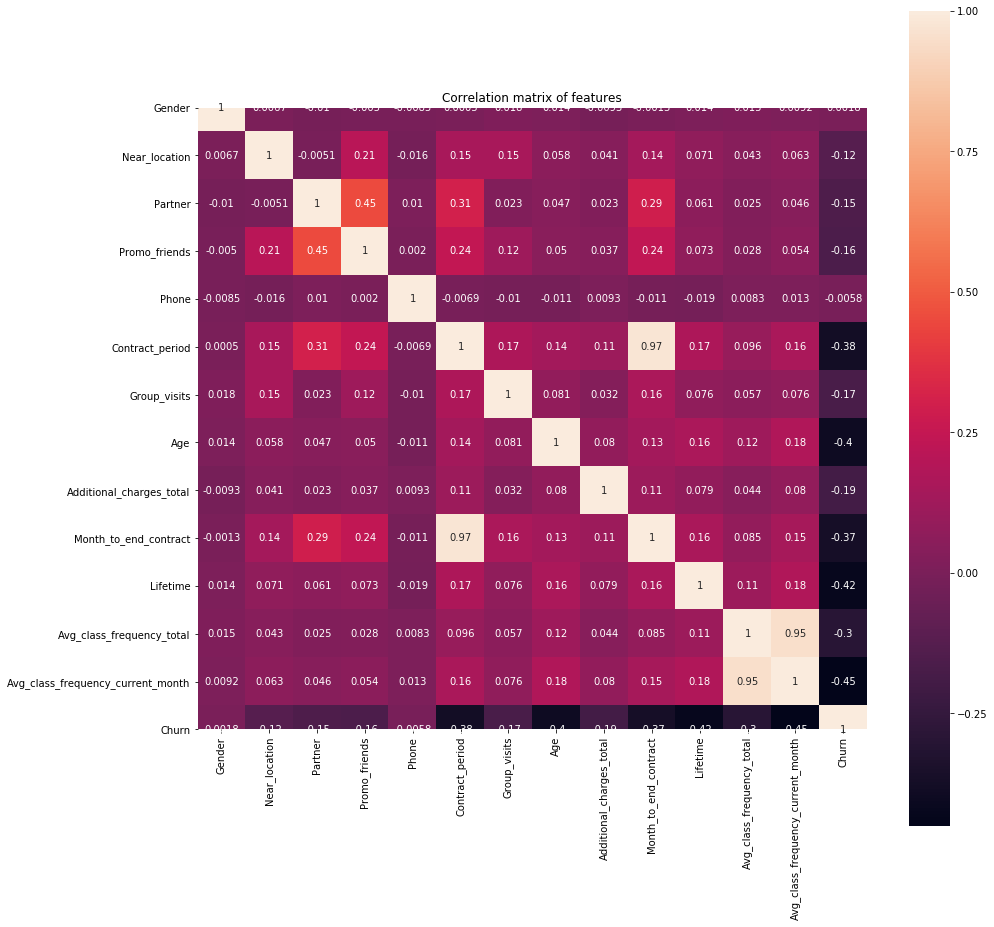

In [18]:
plt.figure(figsize=(15,15))
sns.heatmap(gym.corr(), annot = True, square = True)
#plt.ylim(14, 0)
#plt.xlim(0, 14)
plt.title('Correlation matrix of features')
plt.show()

There are no features highly likely to give us the correct answer. But we have 2 pairs of correlated features `Avg_class_frequency_total` - `Avg_class_frequency_current_month` and `Contract_period` - `Month_to_end_contract`. I've decided not to drop them in order not to 'trading accuracy for a shorter equation' for **LogisticRegression**.   
For ensembles correlated features are not a problem

On the step 2, I examined the basic characteristics of the features, their mean value and standard deviation, and their distribution among the groups of those who stayed and those who left the gym. We looked at the distribution plots for these two groups and built a hitmap to identify correlated features.

[To the Table of Contents](#go_up)   
## Step 3. <a class="anchor" id="step_3"></a> Building a model to predict user churn
Build a binary classification model for customers where the target feature is the user's leaving next month.   
Remember to indicate the random_state parameter when dividing data and defining the algorithm

I decided to test all the models I know for supervised binary classification. Let's define the algorithms for these models

In [19]:
lr_model = LogisticRegression(random_state=0, solver = 'liblinear')
rf_model = RandomForestClassifier(random_state=0, n_estimators = 100)
dt_model = DecisionTreeClassifier(random_state=0)
gb_model =  GradientBoostingClassifier(random_state=0)

models = {'LogisticRegression' : lr_model, 'RandomForestClassifier' : rf_model, 'DecisionTreeClassifier' : dt_model,
         'GradientBoostingClassifier' : gb_model}

[To the Table of Contents](#go_up)   
### 3.1.<a class="anchor" id="step_3_1"></a> Dividing the data into train and validation sets
Divide the data into train and validation sets using the train_test_split() function

Let me remind the ratio again. We are dealing with unbalanced classes

In [20]:
print('The ratio between classes:\n', \
      gym.groupby('Churn')['Gender'].agg({lambda x: 100*x.count()/len(gym),'count'}). \
      rename(columns={'<lambda_0>':'%','count':'Count'}))

The ratio between classes:
        Count     %
Churn             
0       2892  72.3
1       1108  27.7


Splitting data into 2 sets (80% - 20%)

In [21]:
X = gym.drop('Churn', axis = 1)
y = gym['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 

[To the Table of Contents](#go_up)   
### 3.2.<a class="anchor" id="step_3_2"></a> Training the model on the train set with Logistic Regression method

In [22]:
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test) 
lr_probabilities = lr_model.predict_proba(X_test)[:,1]

[To the Table of Contents](#go_up)   
### 3.3.<a class="anchor" id="step_3_3"></a> Training the model on the train set with Random Forest method

In [23]:
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test) 
rf_probabilities = rf_model.predict_proba(X_test)[:,1]

[To the Table of Contents](#go_up)   
### 3.4.<a class="anchor" id="step_3_4"></a> Training the model on the train set with Decision Tree method

In [24]:
dt_model.fit(X_train, y_train)
dt_predictions = dt_model.predict(X_test) 
dt_probabilities = dt_model.predict_proba(X_test)[:,1]

[To the Table of Contents](#go_up)   
### 3.5.<a class="anchor" id="step_3_5"></a> Training the model on the train set with Gradient Boosting method

In [25]:
gb_model.fit(X_train, y_train)
gb_predictions = gb_model.predict(X_test) 
gb_probabilities = gb_model.predict_proba(X_test)[:,1]

[To the Table of Contents](#go_up)   
### 3.6.<a class="anchor" id="step_3_6"></a> Accuracy, precision, recall and other metrics for all models
Evaluate accuracy, balanced accuracy, precision, recall, f1, ROC_AUC and confusion matrix for all the models using the validation data

**Accuracy** - the share of accurate predictions among all predictions **(TP+TN)/(TP+FP+TN+FN)**   
Accuracy only works when classes are balanced, i.e. when objects are distributed almost evenly between the classes, approximately 50/50. So we can use **balanced accuracy**   
**Precision** - the share of correct answers only in the target class  **TP/(TP+FP)**   
**Recall** - ability of the classifier to find all the positive samples  **TP/(TP+FN)**   
**F1 Score** = **2 * precision * recall/(precision+recall)**   
**ROC_AUC** - Receiver Operating Characteristic and Area Under Curve. This metric is a great tool for working with imbalanced classes

So here is a function calculating all the metrics mentioned above

In [26]:
def calculate_metrics(model, X_test, y_test):
    return [round(accuracy_score(y_test,model.predict(X_test)),2),
            round(balanced_accuracy_score(y_test,model.predict(X_test)),2),
            round(precision_score(y_test,model.predict(X_test)),2),
            round(recall_score(y_test,model.predict(X_test)),2),
            round(f1_score(y_test,model.predict(X_test)),2),
            round(roc_auc_score(y_test,model.predict_proba(X_test)[:,1]),2),
            confusion_matrix(y_test, model.predict(X_test))[0],
            confusion_matrix(y_test, model.predict(X_test))[1]]

In [27]:
metrics_names = ['Accuracy','Balanced accuracy','Precision','Recall','F1','ROC_AUC','Confusion Matrix','']
metrics = pd.DataFrame(index = metrics_names)

I also tried playing with different threshold values, but these options did not improve the values of the main metrics.

In [28]:
# threshold = .6
# lr_custom_predictions = [0 if i<threshold else 1 for i in lr_probabilities]
# rf_custom_predictions = [0 if i<threshold else 1 for i in rf_probabilities]

In [29]:
# print('Accuracy: {:.2f}'.format(accuracy_score(y_test,lr_custom_predictions)))
# print('Balanced accuracy: {:.2f}'.format(balanced_accuracy_score(y_test,lr_custom_predictions)))
# print('Precision: {:.2f}'.format(precision_score(y_test,lr_custom_predictions)))
# print('Recall: {:.2f}'.format(recall_score(y_test,lr_custom_predictions)))
# print('F1: {:.2f}'.format(f1_score(y_test,lr_custom_predictions)))
# print('ROC_AUC: {:.2f}'.format(roc_auc_score(y_test,lr_probabilities)))
# print('Confusion Matrix: \n{}'.format(confusion_matrix(y_test, lr_custom_predictions)))

# print('Accuracy: {:.2f}'.format(accuracy_score(y_test,rf_custom_predictions)))
# print('Balanced accuracy: {:.2f}'.format(balanced_accuracy_score(y_test,rf_custom_predictions)))
# print('Precision: {:.2f}'.format(precision_score(y_test,rf_custom_predictions)))
# print('Recall: {:.2f}'.format(recall_score(y_test,rf_custom_predictions)))
# print('F1: {:.2f}'.format(f1_score(y_test,rf_custom_predictions)))
# print('ROC_AUC: {:.2f}'.format(roc_auc_score(y_test,lr_probabilities)))
# print('Confusion Matrix: \n{}'.format(confusion_matrix(y_test, rf_custom_predictions)))

[To the Table of Contents](#go_up)   
### 3.7.<a class="anchor" id="step_3_7"></a> Comparing the models
Use accuracy, precision, and recall to compare the models. Which model gave better results?

Let's compare all the metrics for all our trained models:

In [30]:
for name, model in models.items():
    metrics[name] = calculate_metrics(model, X_test, y_test)
metrics

,LogisticRegression,RandomForestClassifier,DecisionTreeClassifier,GradientBoostingClassifier
Accuracy,0.92,0.93,0.9,0.93
Balanced accuracy,0.88,0.9,0.87,0.91
Precision,0.89,0.86,0.82,0.87
Recall,0.8,0.86,0.81,0.87
F1,0.84,0.86,0.82,0.87
ROC_AUC,0.96,0.97,0.87,0.98
Confusion Matrix,"[569, 21]","[561, 29]","[552, 38]","[563, 27]"
,"[42, 168]","[30, 180]","[39, 171]","[28, 182]"


We have calculated the basic metrics for all 4 models. They all perform well, but ensemples yields the best results. And the metrics for **GradientBoostingClassifier** are even higher than the metrics for **RandomForestClassifier**.
However, **LogisticRegression** gives the best True Positive score in the Confusion Matrix.   
I think **GradientBoostingClassifier** can be considered the best model for this task.

[To the Table of Contents](#go_up)   
### 3.8.<a class="anchor" id="step_3_8"></a> Importance of Features

Let's compare the importance of the features. I will sort them according to the best model for our task - **GradientBoostingClassifier**

In [31]:
feature_importances = pd.DataFrame(zip(rf_model.feature_importances_, dt_model.feature_importances_, 
                            gb_model.feature_importances_), index=X.columns, 
                        columns=['RandomForestClassifier','DecisionTreeClassifier','GradientBoostingClassifier'])
feature_importances.sort_values(by='GradientBoostingClassifier', ascending = False)

,RandomForestClassifier,DecisionTreeClassifier,GradientBoostingClassifier
Lifetime,0.257049,0.342226,0.421373
Avg_class_frequency_current_month,0.226344,0.226192,0.241534
Avg_class_frequency_total,0.133736,0.126839,0.114206
Age,0.114173,0.079277,0.083150
Month_to_end_contract,0.065063,0.091269,0.079598
Contract_period,0.052559,0.026174,0.031791
Additional_charges_total,0.086936,0.075981,0.021279
Group_visits,0.015937,0.009525,0.005175
Promo_friends,0.011867,0.011170,0.001661
Near_location,0.008231,0.004210,0.000167


The most important features for the **GradientBoostingClassifier** model are `Lifetime`, `Avg_class_frequency_current_month` and `Avg_class_frequency_total`. The top three look the same for all three models. Least Important - `Phone`, `Gender` and `Partner`.   
   
The **LogisticRegression** model has no attribute `feature_importances_`, but we can compare zero coefficients using the `coef_` attribute

In [32]:
feature_importances_lr = pd.DataFrame(lr_model.coef_[0], columns = ['LogisticRegression'], index=X.columns)
feature_importances_lr.sort_values(by='LogisticRegression', ascending = False)

,LogisticRegression
Avg_class_frequency_total,2.897347
Phone,0.305182
Gender,0.063457
Near_location,0.027196
Additional_charges_total,-0.003695
Month_to_end_contract,-0.064542
Contract_period,-0.134734
Partner,-0.137025
Age,-0.176799
Promo_friends,-0.448965


The highest absolute coefficients are for the `Avg_class_frequency_total` and `Avg_class_frequency_current_month` features, our correlated features.

On the step 3, we built 4 machine learning models for supervised binary classification - **LogisticRegression**, **RandomForestClassifier**, **DecisionTreeClassifier**, **GradientBoostingClassifier**.   
The data was splitted into training and test groups (80% and 20%), and using this data, the models learned to predict the customers' churn. The main metrics for all these models were calculated and based on their results, the best model for this task was chosen - **GradientBoostingClassifier**

[To the Table of Contents](#go_up)   
## Step 4. <a class="anchor" id="step_4"></a>Creating user clusters  
Set aside the column with data on churn and identify object (user) clusters.   

Let's try to see what groups users can be splitted into and what their group portrait is.   
The first step is data standardization

### 4.1.<a class="anchor" id="step_4_1"></a> Standardizing the data   

In [33]:
scaler = StandardScaler()
X_sc = scaler.fit_transform(gym.drop('Churn', axis=1)) 

[To the Table of Contents](#go_up)   
### 4.2.<a class="anchor" id="step_4_2"></a> Matrix of distances and dendrogram
Use the linkage() function to build a matrix of distances based on the standardized feature matrix and plot a dendrogram. Note: rendering the dendrogram may take time! Use the resulting graph to estimate the number of clusters you can single out

In [34]:
linked = linkage(X_sc, method = 'ward') 
linked[:5]

array([[9.70000000e+01, 3.22200000e+03, 1.00990653e-01, 2.00000000e+00],
       [2.61000000e+02, 3.17900000e+03, 1.22634574e-01, 2.00000000e+00],
       [8.90000000e+02, 1.75000000e+03, 1.28123291e-01, 2.00000000e+00],
       [2.10100000e+03, 3.77300000e+03, 1.44188037e-01, 2.00000000e+00],
       [7.50000000e+01, 1.64600000e+03, 1.46525871e-01, 2.00000000e+00]])

The Matrix of distances is built, now the dendrogram. At the same time, we will check how much time is spent on building it

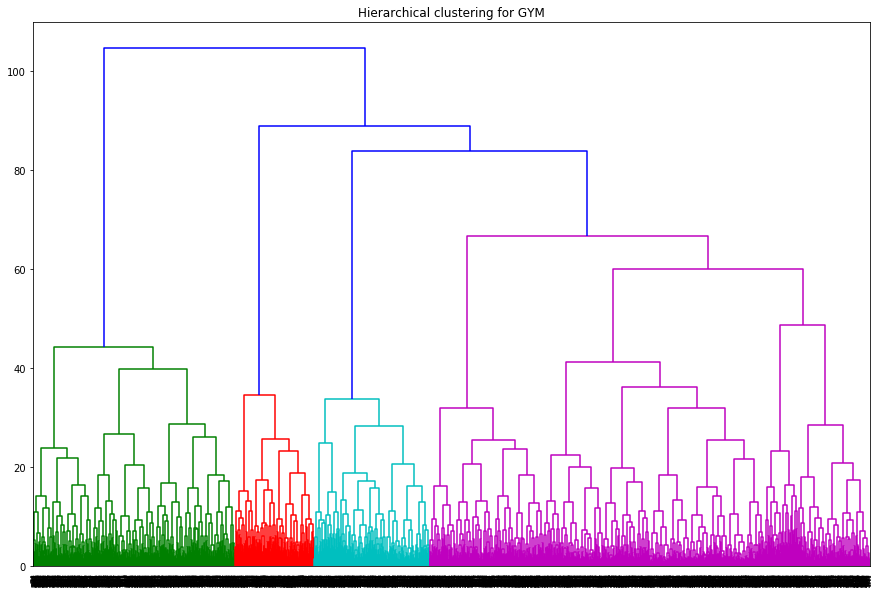

Time in seconds to build this dendrogram - 73


In [35]:
start = time.time()

plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top', truncate_mode = 'level')
plt.title('Hierarchical clustering for GYM')
plt.show() 

end = time.time()

print('Time in seconds to build this dendrogram - {}'.format(round(end - start)))

The suggested optimal number of clusters (4) corresponds to the four different colors on the plot.   
I will try to test the **elbow method** in addition.The method consists of plotting the explained variation as a function of the number of clusters, and picking the elbow of the curve as the number of clusters to use. 

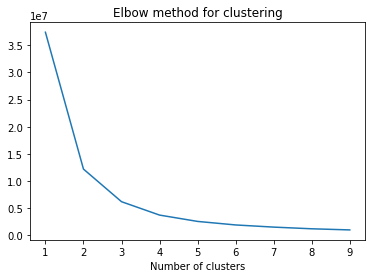

In [36]:
#sse-sum of squared errors
sse={}
data = gym.drop('Churn', axis=1)
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data)
    data["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.title('Elbow method for clustering')
plt.show()

I am somewhat in doubt, the **elbow method** suggest the number of clusters is 3 or 4 (definitely not 5). I will choose **4**, considering the dendrogram as well, although I honestly admit that I am not sure of my decision. In the draft, I built models with 2-5 clusters, and none seemed optimal to me.

[To the Table of Contents](#go_up)   
### 4.3.<a class="anchor" id="step_4_3"></a> Training the clustering model with the K-means algorithm
Train the clustering model with the K-means algorithm and predict customer clusters.    
(Let the number of clusters be n=5, so that it'll be easier to compare your results with those of other students. However, in real life, no one will give you such hints, so you'll have to decide based on the graph from the previous step.)  
   
   
I will build a 4 cluster model as I mentioned above   

In [37]:
km = KMeans(n_clusters = 4, random_state=0)
labels = km.fit_predict(X_sc)
gym['cluster'] = labels
print('Clusters:\n', \
      gym.groupby('cluster')['Gender'].agg({lambda x: 100*x.count()/len(gym),'count'}). \
      rename(columns={'<lambda_0>':'%','count':'Count'}))

Clusters:
          Count       %
cluster               
0          386   9.650
1         1479  36.975
2         1057  26.425
3         1078  26.950


Using the distance matrix, we built a model of 4 clusters. Users are not evenly distributed into clusters. However, they shouldn't

In [38]:
print('Silhouette_score: {:.2f}'.format(silhouette_score(X_sc, labels)))

Silhouette_score: 0.13


The **silhouette_score** metric shows a very low value. Metrics for models with a different number of clusters were close to this

[To the Table of Contents](#go_up)   
### 4.4.<a class="anchor" id="step_4_4"></a> Mean feature values for clusters
Look at the mean feature values for clusters. Does anything catch your eye?

In [39]:
gym.groupby('cluster').mean().iloc[:,0:9]

,Gender,Near_location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Additional_charges_total
cluster,,,,,,,,,
0,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179
1,0.486815,0.759297,0.381339,0.190669,1.0,1.899256,0.292765,28.048005,129.704525
2,0.544939,0.861873,0.343425,0.205298,1.0,2.403027,0.447493,29.989593,157.358764
3,0.503711,0.940631,0.777365,0.572356,1.0,10.697588,0.536178,29.912801,161.363032


In [40]:
gym.groupby('cluster').mean().iloc[:,9:]

,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
cluster,,,,,
0,4.466321,3.940415,1.854211,1.723967,0.284974
1,1.805274,2.235294,1.204610,0.951590,0.580122
2,2.239357,4.704825,2.724796,2.711132,0.092715
3,9.768089,4.730056,1.983884,1.975592,0.038961


The mean values of the features for the clusters tell us the following:   
As for `Gender`, the distribution across clusters is almost even - a little more men in **clusters 0** and **2**, and a little more women in **cluster 1**. A clear preponderance for the `Partner` and `Promo_friends` features for **cluster 3**. None of the users from **cluster 0** doesn't provide phone number. The longest `Contract_period`, `Month_to_end_contract` is in **cluster 3**. It is difficult to say anything by `Age`, the average value in all **4 clusters** is 28-30 years old, as in the whole data. `Additional_charges_total` is higher, again, for **cluster 3**. `Lifetime` is approximately the same for **clusters 2** and **3**, and the shortest for **cluster 1**. The highest attendance is in **cluster 2**, almost 3 times a week. The cluster most prone to churn is **1**.

[To the Table of Contents](#go_up)   
### 4.5.<a class="anchor" id="step_4_5"></a> Distributions of features for the clusters
Plot distributions of features for the clusters. Do you notice anything?

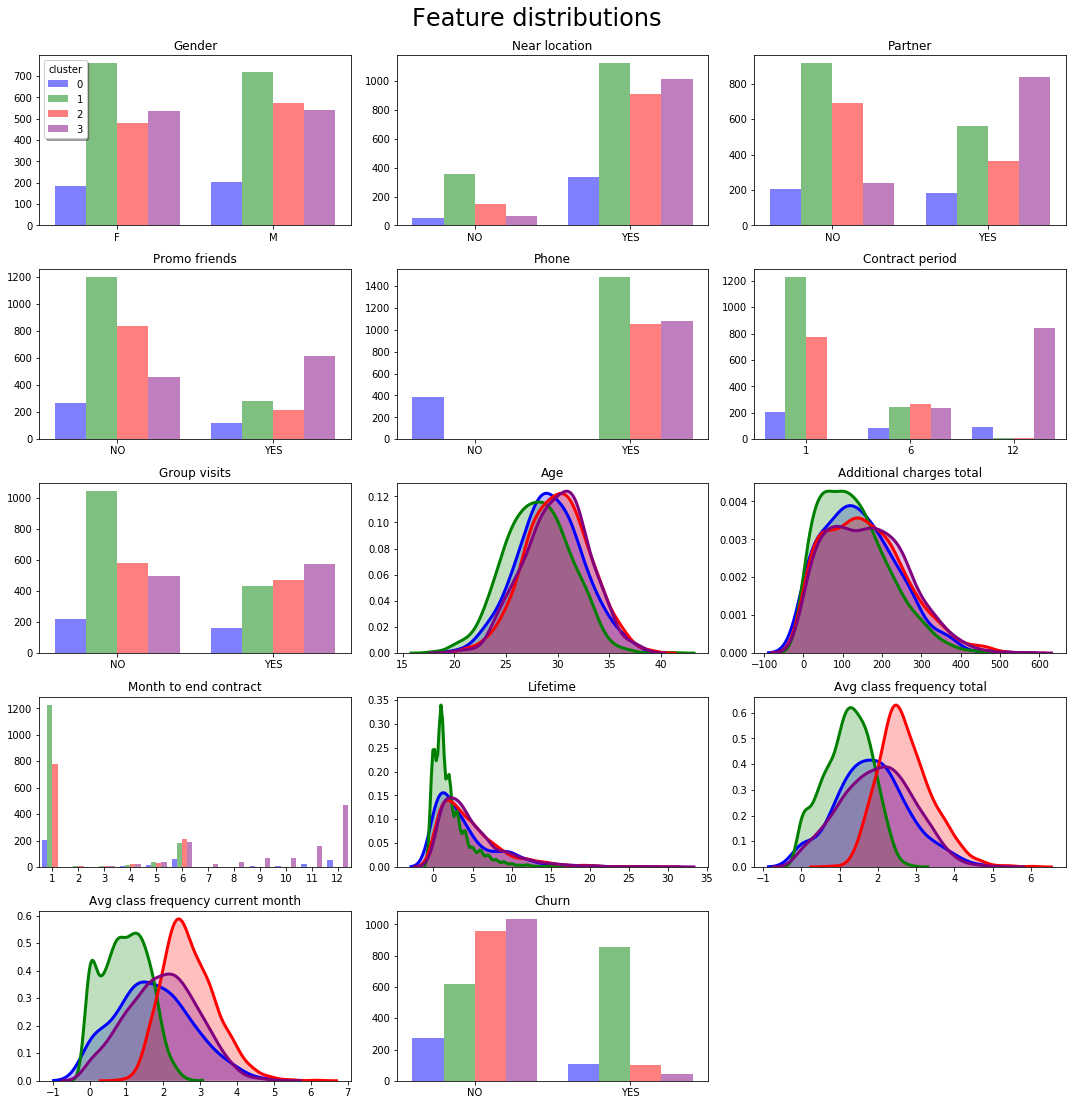

In [41]:
plot_dist(gym,'cluster')

We can see that users from **cluster 1** are the most prone to churn. They have shorter contracts and a lower number of months until the end of the contract. They spend less and go to the gym less often. But the proximity of the facility to home or work is important for users from **all clusters**. **Cluster 3** includes users with the longest contracts, while **cluster 2** is particularly zealous by going to the gym. **Cluster 1** is also more prone to outflow compared to **clusters 2** and **3**.

[To the Table of Contents](#go_up)   
### 4.6.<a class="anchor" id="step_4_6"></a> Calculating the churn rate for the clusters
Calculate the churn rate for each cluster (use the groupby() method). Do they differ in terms of churn rate? Which clusters are prone to leaving, and which are loyal?

In [42]:
gym.pivot_table(
            index='cluster',
            values='Churn', 
            aggfunc=['count',
                     'sum', 
                     lambda x: round(((x == 0).sum() / x.count() - 1) * 100, 2)]).rename(
                    columns={'count':'Total', 'Churn':'', 'sum':'Left', '<lambda>':'Churn_rate,%'}).reset_index()

,cluster,Total,Left,"Churn_rate,%"
,,,,
0,0,386,110,-28.50
1,1,1479,858,-58.01
2,2,1057,98,-9.27
3,3,1078,42,-3.90


As we mentioned above, the cluster with the highest `Churn_rate` is **cluster 1 (58%)**, followed by **cluster 0 (28.5%)**. The most regular customers were in **clusters 2** and **3**, the `Churn_rate` in these clusters is **9%** and **3.9%**, respectively.

At the step 4, a distance matrix was built, and with its help a dendrogram was drawn, which, together with the elbow method, helped to determine the number of clusters into which we had to divide the users of the gym chain. After 4 clusters were formed, the mean value of the features and their distribution on the plots were analyzed. The last task was to calculate the Churn_rate for each cluster.

[To the Table of Contents](#go_up)   
## Step 5. <a class="anchor" id="step_5"></a>Conclusions and basic recommendations on working with customers
Draw conclusions and formulate recommendations regarding the strategy for customer interaction and retention.
You don't need to go into detail. Three or four essential principles and examples of their implementation in the form of specific marketing steps will do.


It seems general recommendations need to be splitted into 2 parts - on the one hand, pay attention to customers who are at risk and try to keep them, and on the other hand, encourage regular customers to stay so.   
- As for the first part of the recommendations - as we have seen, the length of the contract and the number of months until the end of the contract play an important role in the retention of users, and therefore, perhaps, it is necessary to offer clients who can leave the gym profitable long contracts, increase engagement, check whether there were any errors on the part of the client service. It might be worth asking clients what happens if they haven't been to the gym for 2 weeks.
- The second part of the recommendations related to loyal users also includes high visitor engagement, for example,social networks activities, profitable contract renewal offers. Rewards, discounts, free bonuses, etc. Is a great way to engage customers. The opportunity to receive a good reward motivates users not to cancel the contract.

[To the Table of Contents](#go_up)   
## General conclusions <a class="anchor" id="step_6"></a>

The project consisted of 5 steps.
- On the **Step 1**, the data was downloaded and opened, the basic information was examined.  
- The **Step 2** was dedicated to Exploratory data analysis (EDA). The basic characteristics of the features have been studied, their mean value and standard deviation have been thoroughly analyzed. Distribution features among the groups of those who stayed and those who left the gym were plotted (countplots for discrete values and histograms for continuus values). There was also built a hitmap to identify correlated features.   
- On the **Step 3**, 4 machine learning models for supervised binary classification were built. The data was splitted into training and test groups, and the models learned to predict the customers' churn. The main metrics for all these models were calculated and based on their results, the best model for this task was chosen.  
- The **Step 4** was devoted to cluster analysis. The number of clusters was determined using a dendrogram. The clusters were analyzed in terms of mean and feature distribution.
- On the **Step 5**, recommendations were given regarding user retention.

[To the Table of Contents](#go_up)   